# Volcano and MA Plot Visualization for Omics Data

> This notebook provides interactive visualization tools for displaying omics data in two common formats: Volcano plots and MA plots. 


In [ ]:
#| default_exp diff_expr

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

/Users/MTinti/miniconda3/envs/work3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


## Data Loading and Processing

> The PlotData class handles loading data from CSV files and mapping columns to standard names. 

In [ ]:
#| export
class PlotData:
    def __init__(self, file_path, column_mapping=None, log_fdr=False):
        """
        Initialize the PlotData class for various omics experiments.
        
        Parameters:
        -----------
        file_path : str
            Path to the CSV file containing omics data
        column_mapping : dict, optional
            Dictionary mapping standard column names to the actual column names in the file
            Default column names expected: 'log2fc', 'fdr', 'avg_intensity', 'id', 'description'
        log_fdr : bool, optional
            Whether to calculate -log10 of FDR values (default: False)
        """
        self.file_path = file_path
        self.column_mapping = column_mapping or {
            'log2fc': 'logFC',
            'fdr': 'adj.P.Val',
            'avg_intensity': 'AveExpr',
            'id': None,  # Will use index if None
            'description': None  # May not be present in all datasets
        }
        self.log_fdr = log_fdr  # Store as instance variable
        self.data = None
        self.load_data()
        
    def load_data(self):
        """Load and process the data from the CSV file."""
        try:
            self.data = pd.read_csv(self.file_path, index_col=0)
            
            # Map the columns and store as class attributes
            for std_col, file_col in self.column_mapping.items():
                if file_col is None and std_col == 'id':
                    # Use index as ID if not specified
                    setattr(self, std_col, self.data.index.values)
                elif file_col is None and std_col == 'description':
                    # Set empty descriptions if not available
                    setattr(self, std_col, np.array([''] * len(self.data)))
                elif file_col in self.data.columns:
                    setattr(self, std_col, self.data[file_col].values)
                else:
                    raise ValueError(f"Column '{file_col}' not found in the data file")
            
            # Calculate -log10(FDR) for volcano plot
            if self.log_fdr:  # Use self.log_fdr instead of log_fdr
                self.log10_fdr = -np.log10(self.fdr)
            else:
                self.log10_fdr = self.fdr
            
            return True
            
        except Exception as e:
            print(f"Error loading data: {e}")
            return False
        
    def get_significant_indices(self, log2fc_threshold=1.0, fdr_threshold=0.05):
        """
        Get indices of significant features based on thresholds.

        Parameters:
        -----------
        log2fc_threshold : float
            Absolute log2 fold change threshold
        fdr_threshold : float
            FDR threshold

        Returns:
        --------
        numpy.ndarray
            Indices of significant features
        """
        significant = (np.abs(self.log2fc) >= log2fc_threshold) & (self.fdr <= fdr_threshold)
        return np.where(significant)[0]
    
    def get_data_for_plotting(self):
        """
        Get all data in a format ready for plotting.

        Returns:
        --------
        dict
            Dictionary with all data needed for plotting
        """
        return {
            'log2fc': self.log2fc,
            'log10_fdr': self.log10_fdr,
            'avg_intensity': self.avg_intensity,
            'id': self.id,
            'description': self.description,
            'fdr': self.fdr
        }    

In [ ]:
#| export
# empty container for plotting data with standard names.
empty_data_dict = {
            'log2fc': np.nan,
            'log10_fdr': np.nan,
            'avg_intensity': np.nan,
            'id': np.nan,
            'description': np.nan,
            'fdr': np.nan
        }

In [ ]:
empty_data_dict

{'log2fc': nan,
 'log10_fdr': nan,
 'avg_intensity': nan,
 'id': nan,
 'description': nan,
 'fdr': nan}

## Visualization Function
> Now we'll define the function to generate the side-by-side volcano and MA plots:

In [ ]:
#| export
def create_volcano_ma_plots(plot_data, 
                          log2fc_threshold=1.0, 
                          fdr_threshold=0.05, 
                          plot_title="Volcano and MA Plots", 
                          width=1000, 
                          height=500):
    """
    Create side-by-side volcano and MA plots using Plotly.
    
    Parameters:
    -----------
    plot_data : PlotData
        A PlotData object containing the necessary data
    log2fc_threshold : float, optional
        Threshold for log2 fold change significance (default: 1.0)
    fdr_threshold : float, optional
        Threshold for FDR significance (default: 0.05)
    plot_title : str, optional
        Title for the plot (default: "Volcano and MA Plots")
    width : int, optional
        Width of the plot in pixels (default: 1000)
    height : int, optional
        Height of the plot in pixels (default: 500)
        
    Returns:
    --------
    plotly.graph_objects.Figure
        The created figure object
    """
    # Get the data for plotting
    plotting_data = plot_data.get_data_for_plotting()
    
    # Get significant indices
    sig_indices = plot_data.get_significant_indices(log2fc_threshold, fdr_threshold)
    
    # Create color array (black for non-significant, red for significant)
    colors = ['black'] * len(plotting_data['log2fc'])
    for idx in sig_indices:
        colors[idx] = 'red'
    
    # Create size array (small for non-significant, larger for significant)
    sizes = [5] * len(plotting_data['log2fc'])
    for idx in sig_indices:
        sizes[idx] = 10
    
    # Create opacity array (transparent for non-significant, opaque for significant)
    opacities = [0.3] * len(plotting_data['log2fc'])
    for idx in sig_indices:
        opacities[idx] = 1.0
    
    # Create simplified hover text with only protein ID and description
    hover_texts = []
    for i in range(len(plotting_data['id'])):
        id_text = plotting_data['id'][i]
        desc_text = plotting_data['description'][i] if plotting_data['description'][i] else "No description"
        
        hover_texts.append(f"ID: {id_text}<br>Description: {desc_text}")
    
    # Create figure with subplots
    fig = make_subplots(rows=1, cols=2,
                       subplot_titles=["Volcano Plot", "MA Plot"],
                       horizontal_spacing=0.1)
    
    # Add Volcano plot (left)
    volcano_scatter = go.Scatter(
        x=plotting_data['log2fc'],
        y=plotting_data['log10_fdr'],
        mode='markers',
        marker=dict(
            color=colors,
            size=sizes,
            opacity=opacities,
            line=dict(width=1, color='black')
        ),
        text=hover_texts,
        hoverinfo='text',
        name='Volcano Plot',
        showlegend=False,
        hovertemplate='%{text}<extra></extra>'
    )
    
    fig.add_trace(volcano_scatter, row=1, col=1)
    
    # Add MA plot (right)
    ma_scatter = go.Scatter(
        x=plotting_data['avg_intensity'],
        y=plotting_data['log2fc'],
        mode='markers',
        marker=dict(
            color=colors,
            size=sizes,
            opacity=opacities,
            line=dict(width=1, color='black')
        ),
        text=hover_texts,
        hoverinfo='text',
        name='MA Plot',
        showlegend=False,
        hovertemplate='%{text}<extra></extra>'
    )
    
    fig.add_trace(ma_scatter, row=1, col=2)
    
    # Update layout
    fig.update_layout(
        title=plot_title,
        width=width,
        height=height,
        showlegend=False,
        hovermode='closest'
    )
    
    # Update x and y axis labels
    fig.update_xaxes(title_text="log2 Fold Change", row=1, col=1)
    fig.update_yaxes(title_text="-log10 FDR", row=1, col=1)
    
    fig.update_xaxes(title_text="Average Expression", row=1, col=2)
    fig.update_yaxes(title_text="log2 Fold Change", row=1, col=2)
    
    return fig

## Example Usage
> Let's demonstrate how to use these functions with a real dataset:

In [ ]:
column_mapping = {
    'log2fc': 'logFC',            # logFC column from your data
    'fdr': 'FDR',                # FDR column from your data
    'avg_intensity': 'log_AveExpr', # log_AveExpr column from your data
    'id': 'Gene_id',            # Gene_acc column from your data
    'description': 'Desc'         # Desc column from your data
}

file_path = '../tests/volcano_plots/for_web_limma_WT-C3.csv.zip'
# Create the PlotData instance
plot_data = PlotData(file_path, column_mapping)

# Print some information about the loaded data
print(f"Data loaded: {plot_data.data is not None}")
print(f"Number of rows: {len(plot_data.data) if plot_data.data is not None else 0}")
print(f"First few IDs: {plot_data.id[:5] if hasattr(plot_data, 'id') else 'Not loaded'}")

# Get significant features
sig_indices = plot_data.get_significant_indices(log2fc_threshold=0.2, fdr_threshold=0.1)
print(f"Number of significant features: {len(sig_indices)}")

# Quick access to all plotting data
plotting_data = plot_data.get_data_for_plotting()

Data loaded: True
Number of rows: 6205
First few IDs: ['Blasticidin' 'Puromycin' 'Tb05.5K5.100;Tb927.5.4450'
 'Tb05.5K5.110;Tb927.5.4460' 'Tb05.5K5.120;Tb927.5.4470']
Number of significant features: 80


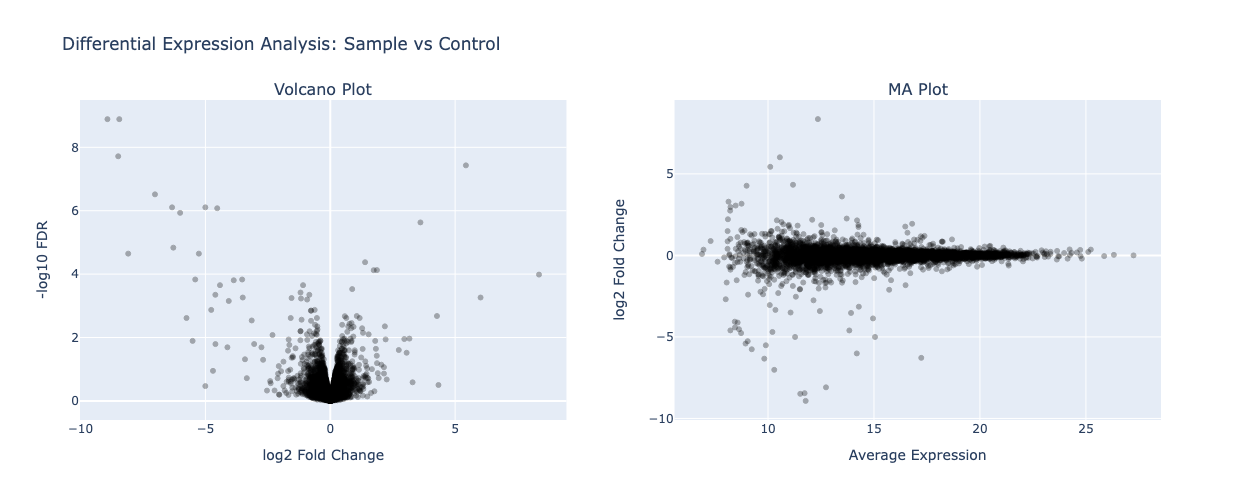

In [ ]:
# Create interactive plots
fig = create_volcano_ma_plots(
    plot_data,
    plot_title="Differential Expression Analysis: Sample vs Control"
)

# Show the plot
fig.show()